<h1 style="text-align: center;">Sleeping score</h1>

<h2 style="text-align: center;"><a id="table_contents">Table of contents</a></h2>

<a id='introduction'></a>
# 1. Introduction 
<hr>
This machine learning project leverages four datasets sourced from a friend's Garmin Connect account.    

The datasets include daily records of sports activities, heart rate, calories consumption, and nightly sleep data. The goal of the project is to predict a sleeping score, on a scale from 0 to 100, using the provided data.

By analyzing patterns and correlations between physical activities, max heart rate during the day, calories consumed and sleep quality, the model aims to offer insights into factors that most significantly impact sleep. The predictive model will aid in optimizing lifestyle choices to enhance overall sleep quality.
<hr>

In [1]:
%load_ext autoreload
%autoreload 2

from functions import *

from sklearn.linear_model import Lasso, LassoCV

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import RandomizedSearchCV

In [2]:
mlflow.set_experiment("Sleeping_score")

mlflow.set_tracking_uri(uri="http://127.0.0.1:8888")

In [3]:
ACTIVITY_RELATED_FEATURES = [
    'Type',	'Activity_distance', 'Activity_calories', 'Duration', 
    'Activity_average_heart_rate', 'Activity_maximum_heart_rate', 'Aerobic_TE', 'Average_running_cadence', 
    'Maximum_running_cadence', 'Average_pace', 'Best_pace', 'Maximum_temperature', 
    'Activity_average_respiratory_frequency', 'Activity_minimum_respiratory_frequency', 'Activity_maximum_respiratory_frequency',
    'Travel_time', 'Elapsed_time', 'Minimum_altitude', 'Maximum_altitude', 
    'N_activities', 'Total_duration', 'Total_distance', 'Total_aerobic_TE'
]

# 2. Modeling

## 2.1. Baseline model <a id='Baseline'></a>
<a href="#table_contents">Table of contents</a>
<hr>
Baseline model containing all features

In [4]:
# Desired scoring metrics
scoring = ('neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2')

# Dictionary containing all the metrics for the models tested
train_cv_dict = {}
test_cv_dict = {}

In [5]:
df_work = pd.read_csv("Data/preprocessed_data.csv")

df_work.shape

(406, 33)

In [6]:
X_base = df_work.drop(columns=['Date', 'Score', 'Quality'])
y_base = df_work['Score']

In [7]:
random_state = 42

# Keep X raws for error analysis
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_base, y_base, test_size=0.25, random_state=random_state,)

X_train_index = X_train_raw.index
X_test_index = X_test_raw.index

# Standardize all the columns
ct = ColumnTransformer(
    [('standardize', StandardScaler(), [i for i in range(X_train_raw.shape[1])])], 
    remainder='passthrough'
)

# Transform and keep the original index
X_train = pd.DataFrame(ct.fit_transform(X_train_raw), columns=X_train_raw.columns).set_index(X_train_index)
X_test = pd.DataFrame(ct.transform(X_test_raw), columns=X_test_raw.columns).set_index(X_test_index)

In [8]:
run_name = "baseline"

baseline_results = lin_reg_cross_val(
    X=X_train, y=y_train, random_state=random_state,
    k_fold=True, stratified_k_fold=False, n_splits=5,
    scoring=scoring, return_train_score=True, return_estimator=False,
    mlflow_register=False, register_dataset=True, run_name=run_name
)

fill_comparison_df(train_cv_dict, 'rmse', 'baseline', baseline_results)

## 2.2. Feature Selection

### 2.2.1. Lasso

In [9]:
# Looking for best alpha parameter
lasso_cv = LassoCV(
    cv=5,
    max_iter=2000,
    random_state=random_state
)

lasso_cv.fit(X_train, y_train)

best_alpha = lasso_cv.alpha_

# Lasso model
lasso = Lasso(
    alpha=best_alpha,
    random_state=random_state
)

lasso.fit(X_train, y_train)
lasso_features = X_train.columns[lasso.coef_ != 0]

In [10]:
lin_reg_lasso_results = lin_reg_cross_val(
    X=X_train[lasso_features], y=y_train, random_state=random_state,
    k_fold=True, stratified_k_fold=False, n_splits=5,
    scoring=scoring, return_train_score=True
)

fill_comparison_df(train_cv_dict, 'rmse', 'lin_reg_lasso', lin_reg_lasso_results)

### 2.2.2. Correlation

In [11]:
corr_matrix = X_base.corr(method='pearson')
corr_matrix = corr_matrix['Sleep_duration'][abs(corr_matrix['Sleep_duration']) >= 0.1]

corr_features = corr_matrix.index

In [12]:
lin_reg_corr_results = lin_reg_cross_val(
    X=X_train[corr_features], y=y_train, random_state=random_state,
    k_fold=True, stratified_k_fold=False, n_splits=5,
    scoring=scoring, return_train_score=True
)

fill_comparison_df(train_cv_dict, 'rmse', 'lin_reg_corr', lin_reg_corr_results)

## 2.3. Random Forest

In [13]:
rf_params = {
    "max_depth": None,
}

In [14]:
# Random forest with all features
rf_all_results = random_forest_cross_val(
    X=X_train, y=y_train, rf_params=None , random_state=random_state,
    k_fold=True, stratified_k_fold=False, n_splits=5,
    scoring=scoring, return_train_score=True,
    mlflow_register=False, register_dataset=True, run_name="",
)

fill_comparison_df(train_cv_dict, 'rmse', 'rf_all', rf_all_results)

In [15]:
# Random forest with lasso selected features
rf_lasso_results = random_forest_cross_val(
    X=X_train[lasso_features], y=y_train, rf_params=None , random_state=random_state,
    k_fold=True, stratified_k_fold=False, n_splits=5,
    scoring=scoring, return_train_score=True,
    mlflow_register=False, register_dataset=True, run_name="",
)

fill_comparison_df(train_cv_dict, 'rmse', 'rf_lasso', rf_lasso_results)

In [16]:
# Random forest with correlation selected features
rf_corr_results = random_forest_cross_val(
    X=X_train[corr_features], y=y_train, rf_params=None , random_state=random_state,
    k_fold=True, stratified_k_fold=False, n_splits=5,
    scoring=scoring, return_train_score=True,
    mlflow_register=False, register_dataset=True, run_name="",
)

fill_comparison_df(train_cv_dict, 'rmse', 'rf_corr', rf_corr_results)

## 2.4. Gradient Boosting

In [17]:
# Gradient Boosting with all features
gboost_all_results = gradient_boosting_cross_val(
    X=X_train, y=y_train, gboost_params=None, random_state=random_state,
    k_fold=True, stratified_k_fold=False, n_splits=5,
    scoring=scoring, return_train_score=True,
    mlflow_register=False, register_dataset=True, run_name="",
)

fill_comparison_df(train_cv_dict, 'rmse', 'gboost_all', gboost_all_results)

In [18]:
# Gradient Boosting with lasso features
gboost_lasso_results = gradient_boosting_cross_val(
    X=X_train[lasso_features], y=y_train, gboost_params=None, random_state=random_state,
    k_fold=True, stratified_k_fold=False, n_splits=5,
    scoring=scoring, return_train_score=True,
    mlflow_register=False, register_dataset=True, run_name="",
)

fill_comparison_df(train_cv_dict, 'rmse', 'gboost_lasso', gboost_lasso_results)

In [19]:
# Gradient Boosting with correlation features
gboost_corr_results = gradient_boosting_cross_val(
    X=X_train[corr_features], y=y_train, gboost_params=None, random_state=random_state,
    k_fold=True, stratified_k_fold=False, n_splits=5,
    scoring=scoring, return_train_score=True,
    mlflow_register=False, register_dataset=True, run_name="",
)

fill_comparison_df(train_cv_dict, 'rmse', 'gboost_corr', gboost_corr_results)

## 2.5. Comparison

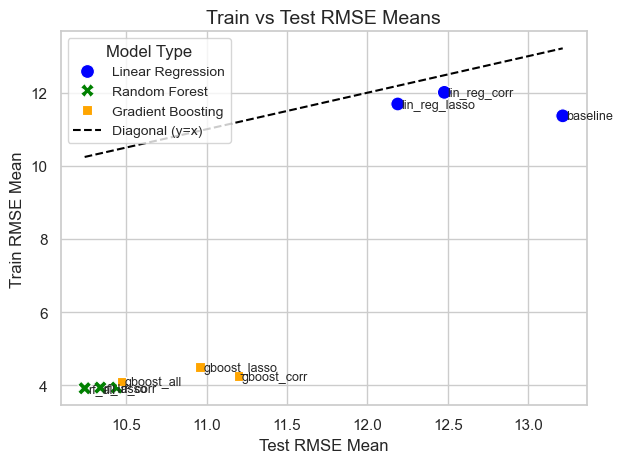

In [20]:
# Uncomment the following line to display an interactive plotly graph
# plot_models_metrics(train_cv_dict, ['baseline', 'lin_reg', 'rf', 'gboost'])

plot_models_metrics_seaborn(train_cv_dict, ['baseline', 'lin_reg', 'rf', 'gboost'])

The above plot shows that linear regression performs poorly on this dataset, regardless of used features.    
Random forests and XGBoost performs too well on the training set but poorly on the test set, meaning that it overfits.    
For the rest, only the variables resulting from the lasso selection are retained.

# 3. Random Search CV

## 3.1. Random Forest

In [21]:
X_train_interest = X_train[lasso_features]
X_test_interest = X_test[lasso_features]

rf_params = {
    'n_estimators': [10, 20, 30, 50, 100, 200, 300, 500],
    'max_depth': [1, 2, 3, 4, 5, 6, 7],
    'min_samples_leaf': [0.01, 0.02, 0.03, 0.05, 0.1, 0.15]
}

clf_rf = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=random_state),
    param_distributions=rf_params,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    n_jobs=-2,
    refit='neg_root_mean_squared_error',
    cv=5,
    random_state=random_state,
    return_train_score=True
)

clf_rf.fit(X_train_interest, y_train)

rf_best_params = clf_rf.best_params_
rf_best_params

{'n_estimators': 200, 'min_samples_leaf': 0.01, 'max_depth': 5}

In [22]:
rf_search_lasso = RandomForestRegressor(
    n_estimators=rf_best_params['n_estimators'],
    max_depth=rf_best_params['max_depth'],
    min_samples_leaf=rf_best_params['min_samples_leaf'],
    random_state=random_state
)

rf_search_lasso.fit(X_train_interest, y_train)

rf_search_lasso_train_pred = np.round(rf_search_lasso.predict(X_train_interest))
rf_search_lasso_test_pred = np.round(rf_search_lasso.predict(X_test_interest))

print(f"Train R2 : {rf_search_lasso.score(X_train_interest, y_train):.2f}\nTest R2 : {rf_search_lasso.score(X_test_interest, y_test):.2f}")
print(f"Train RMSE : {rmse_score(y_train, rf_search_lasso_train_pred):.2f}")
print(f"Test RMSE : {rmse_score(y_test, rf_search_lasso_test_pred):.2f}")

Train R2 : 0.86
Test R2 : 0.85
Train RMSE : 8.03
Test RMSE : 8.24


## 3.2. Gradient Boosting

In [23]:
X_train_interest = X_train[lasso_features]
X_test_interest = X_test[lasso_features]

gboost_params = {
    'learning_rate': [0.001, 0.005, 0.01, 0.02, 0.05],
    'n_estimators': [100, 200, 300, 400, 500, 600, 700],
    'max_depth': [1, 2, 3, 4, 5, 6, 7],
    'min_samples_leaf': [0.01, 0.02, 0.03, 0.05, 0.1, 0.15],
    'ccp_alpha' : [0, 0.01, 0.05, 0.1],
}


clf_gboost = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=random_state),
    param_distributions=gboost_params,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    n_jobs=-2,
    refit='neg_root_mean_squared_error',
    cv=5,
    random_state=random_state,
    return_train_score=True
)

clf_gboost.fit(X_train_interest, y_train)

gboost_best_params = clf_gboost.best_params_
gboost_best_params

{'n_estimators': 500,
 'min_samples_leaf': 0.02,
 'max_depth': 2,
 'learning_rate': 0.01,
 'ccp_alpha': 0.1}

In [24]:
gboost = GradientBoostingRegressor(
    learning_rate=gboost_best_params['learning_rate'],
    n_estimators=gboost_best_params['n_estimators'],
    min_samples_leaf=gboost_best_params['min_samples_leaf'],
    max_depth=gboost_best_params['max_depth'],
    ccp_alpha=gboost_best_params['ccp_alpha'],
    random_state=random_state
)

gboost.fit(X_train_interest, y_train)

print(f"Train R2 : {gboost.score(X_train_interest, y_train):.2f}\nTest R2 : {gboost.score(X_test_interest, y_test):.2f}")
print(f"Train RMSE : {rmse_score(y_train, np.round(gboost.predict(X_train_interest))):.2f}\nTest RMSE : {rmse_score(y_test, np.round(gboost.predict(X_test_interest))):.2f}")

Train R2 : 0.85
Test R2 : 0.85
Train RMSE : 8.24
Test RMSE : 8.31


# 5.Errors analysis
----
Focus on errors made by the random forest model

In [25]:
train_residuals = y_train.values.ravel() - rf_search_lasso_train_pred
test_residuals = y_test.values.ravel() - rf_search_lasso_test_pred

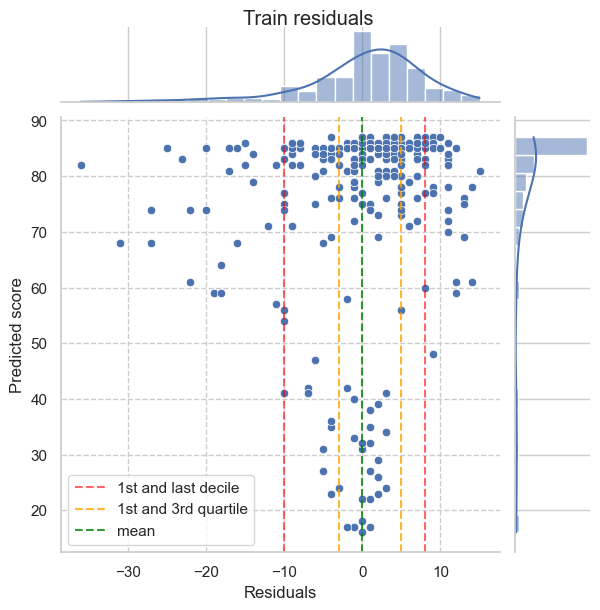

In [26]:
linreg_grid = sns.JointGrid(x=train_residuals, y=rf_search_lasso_train_pred)
linreg_grid.plot_joint(sns.scatterplot)
linreg_grid.plot_marginals(sns.histplot, kde=True)
linreg_grid.set_axis_labels(xlabel='Residuals', ylabel='Predicted score')

# Plot 1st decile, 1st quartile, mean, 3rd quartile and last decile
linreg_grid.ax_joint.grid(True, linestyle='--') 
linreg_grid.ax_joint.axvline(x=np.quantile(train_residuals, q=0.1), color='red', linestyle='--', alpha=0.6, label='1st and last decile')
linreg_grid.ax_joint.axvline(x=np.quantile(train_residuals, q=0.25), color='orange', linestyle='--', alpha=0.8, label='1st and 3rd quartile')
linreg_grid.ax_joint.axvline(x=np.mean(train_residuals), color='green', linestyle='--', alpha=0.8, label='mean')
linreg_grid.ax_joint.axvline(x=np.quantile(train_residuals, q=0.75), color='orange', linestyle='--', alpha=0.8)
linreg_grid.ax_joint.axvline(x=np.quantile(train_residuals, q=0.9), color='red', linestyle='--', alpha=0.6)

linreg_grid.ax_joint.legend(loc='lower left') 

linreg_grid.figure.subplots_adjust(top=0.95)
linreg_grid.figure.suptitle('Train residuals')

plt.show()

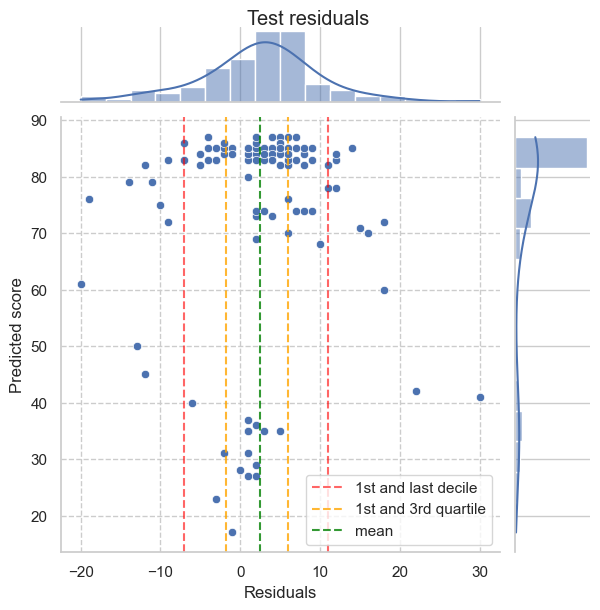

In [27]:
linreg_grid = sns.JointGrid(x=test_residuals, y=rf_search_lasso_test_pred)
linreg_grid.plot_joint(sns.scatterplot)
linreg_grid.plot_marginals(sns.histplot, kde=True)
linreg_grid.set_axis_labels(xlabel='Residuals', ylabel='Predicted score')

# Plot 1st decile, 1st quartile, mean, 3rd quartile and last decile
linreg_grid.ax_joint.grid(True, linestyle='--') 
linreg_grid.ax_joint.axvline(x=np.quantile(test_residuals, q=0.1), color='red', linestyle='--', alpha=0.6, label='1st and last decile')
linreg_grid.ax_joint.axvline(x=np.quantile(test_residuals, q=0.25), color='orange', linestyle='--', alpha=0.8, label='1st and 3rd quartile')
linreg_grid.ax_joint.axvline(x=np.mean(test_residuals), color='green', linestyle='--', alpha=0.8, label='mean')
linreg_grid.ax_joint.axvline(x=np.quantile(test_residuals, q=0.75), color='orange', linestyle='--', alpha=0.8)
linreg_grid.ax_joint.axvline(x=np.quantile(test_residuals, q=0.9), color='red', linestyle='--', alpha=0.6)

linreg_grid.ax_joint.legend(loc='lower right')

linreg_grid.figure.subplots_adjust(top=0.95)
linreg_grid.figure.suptitle('Test residuals')

plt.show()

In [28]:
# Create residual dataframe by concatenating X_train, y_train, train predictions and train residuals.
df_residuals = pd.concat(
    objs=[
        X_train_interest,
        y_train,
        pd.Series(rf_search_lasso_train_pred, index=X_train_interest.index, name="train_predictions"),
        pd.Series(train_residuals, index=X_train_interest.index, name='train_residuals')
    ],
    axis=1
)

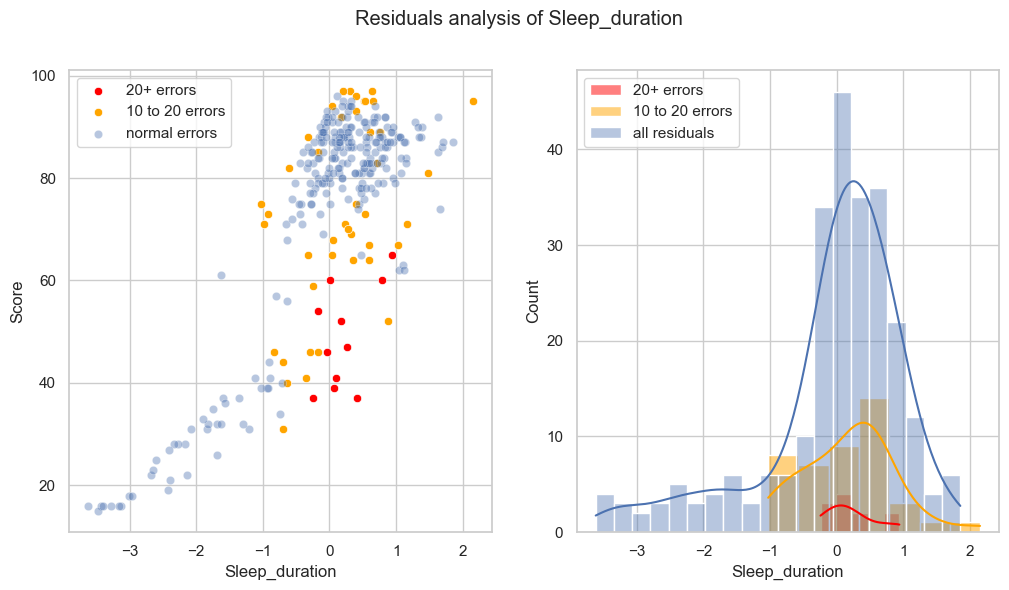

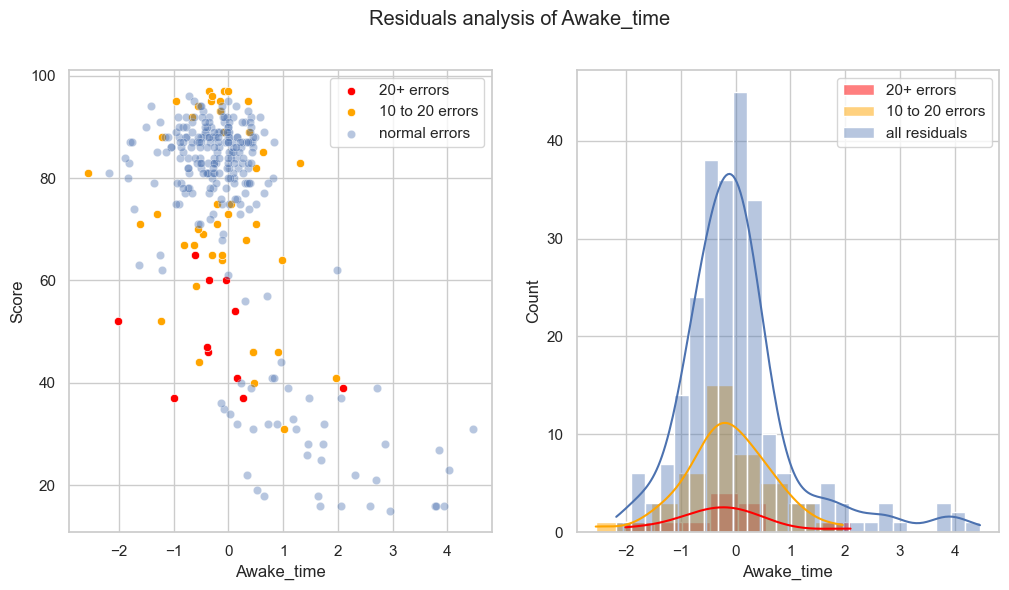

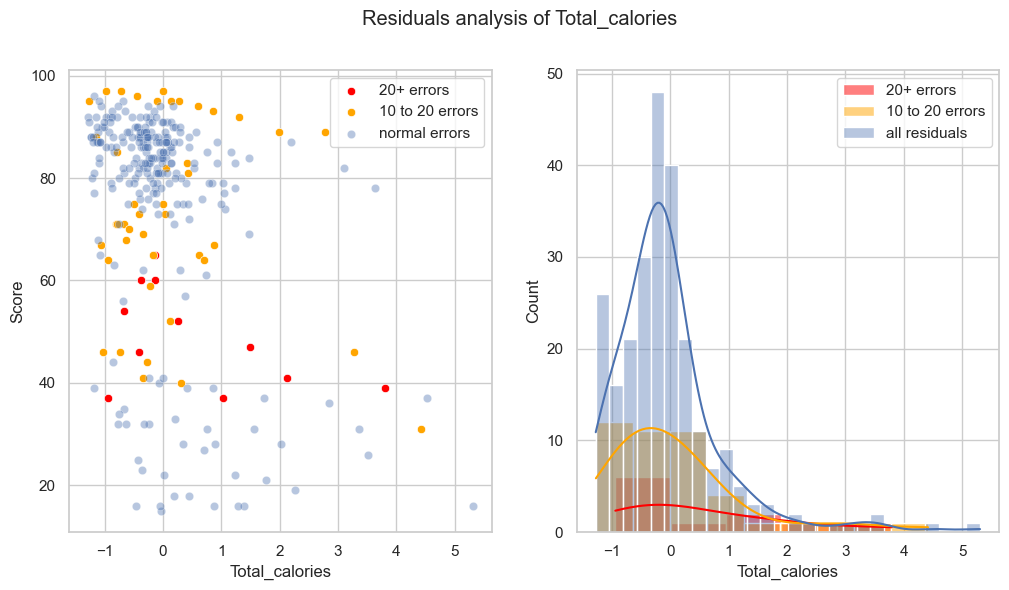

In [31]:
for var in ['Sleep_duration', 'Awake_time', 'Total_calories']:
    residuals_analysis(df_residuals, var)

## Conclusion
---
The model has difficulty explaining why, with non-extreme values for the variables, the sleep score is sometimes average (between 40 and 60).   
This is to be expected, as this range of scores (40-60) is the least representend.